In [837]:
import argparse
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
# from pytorch_lightning.callbacks import ModelCheckpoint

from PIL import Image
from torchvision import transforms
from multimodal.multimodal_data_module import EVAL_DATA_DIR, SOS_TOKEN_ID, EOS_TOKEN_ID, IMAGE_H, IMAGE_W, read_vocab
from multimodal.multimodal_saycam_data_module import MultiModalSAYCamDataModule, EXTRACTED_FRAMES_DIRNAME
from multimodal.coco_captions_data_module import COCOCaptionsDataModule
# from multimodal.multimodal import MultiModalModel
from multimodal.multimodal_lit import MultiModalLitModel
from multimodal.attention_maps import gradCAM, getAttMap, n_inv, imshow
from train import _setup_parser

%matplotlib inline
%load_ext autoreload
%autoreload 2

EVAL_FRAMES_DIRNAME = EVAL_DATA_DIR / "eval"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

checkpoints = [
    "../checkpoints/multimodal_text_encoder_lstm_lr_5e-05_weight_decay_0.1_fix_temperature_True_batch_size_8",
]

checkpoint = Path(checkpoints[-1])
if checkpoint.is_dir():
    checkpoint = list(checkpoint.glob("epoch=*.ckpt"))[0]
print("loading model from", checkpoint)
model = MultiModalLitModel.load_from_checkpoint(checkpoint, map_location=device)
model.eval()
print(model.hparams["args"])

loading model from ../checkpoints/multimodal_text_encoder_lstm_lr_5e-05_weight_decay_0.1_fix_temperature_True_batch_size_8/epoch=199.ckpt
Namespace(accelerator=None, accumulate_grad_batches=1, amp_backend='native', amp_level='O2', augment_frames=True, auto_lr_find=False, auto_scale_batch_size=False, auto_select_gpus=False, batch_size=8, benchmark=False, bias=True, bidirectional=False, check_val_every_n_epoch=1, checkpoint_callback=True, crange=1, default_root_dir=None, deterministic=False, devices=None, distributed_backend=None, dropout_i=0.0, dropout_o=0.0, embedding_dim=512, embedding_type='flat', exp_name='multimodal_text_encoder_lstm_lr_5e-05_weight_decay_0.1_fix_temperature_True_batch_size_8', fast_dev_run=False, finetune_cnn=False, fix_temperature=True, flush_logs_every_n_steps=100, gpus=1, gradient_clip_algorithm='norm', gradient_clip_val=0.0, ipus=None, lambda_lm=0.0, lambda_mm=1.0, limit_predict_batches=1.0, limit_test_batches=1.0, limit_train_batches=1.0, limit_val_batches=1.

In [18]:
# parse empty args
parser = _setup_parser()
args = parser.parse_args("")
# set args
for key, value in model.args.items():
    setattr(args, key, value)
# make the train dataloader deterministic
args.augment_frames = False

# build data module
dataset_name = getattr(args, "dataset", "coco")
DataModuleClass = {
    "saycam": MultiModalSAYCamDataModule,
    "coco": COCOCaptionsDataModule,
}["coco"]
data = DataModuleClass(args)
data.prepare_data()
data.setup()

vocab = data.read_vocab()
idx2word = {v: k for k, v in vocab.items()}

# eval datasets
eval_dev_dataset = data.eval_datasets["val"]
eval_test_dataset = data.eval_datasets["test"]

# dataloaders
eval_dev_dataloader = data.val_dataloader()[0]
eval_test_dataloader = data.test_dataloader()[0]

Calling prepare_data!
All data have already existed. Skipping this step.
Calling setup!


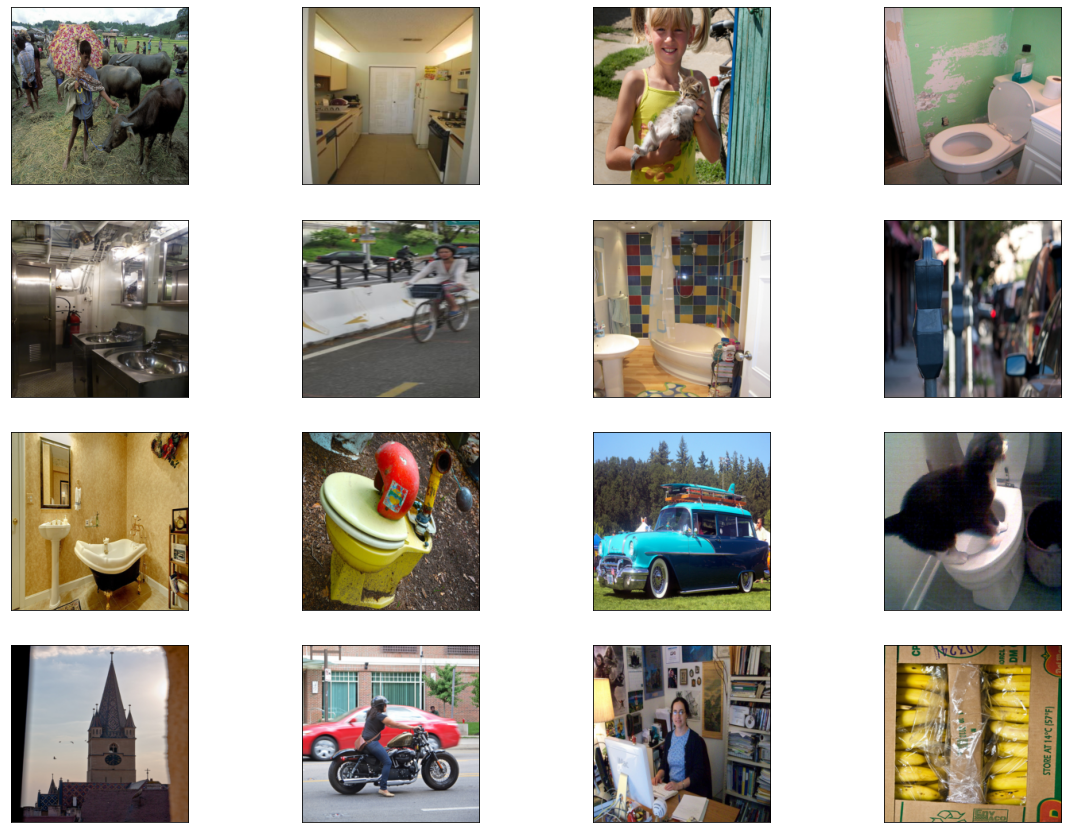

In [23]:
imgs, label, label_len, raw_label = next(iter(eval_dev_dataloader))
original_imgs = n_inv(imgs)

plt.figure(figsize=(20, 15))
for i, original_img in enumerate(original_imgs):
    np_img = original_img.permute((1, 2, 0)).cpu().numpy()

    ax = plt.subplot(4, 4, i+1)
    plt.imshow(np_img)
    plt.xticks([])
    plt.yticks([])

In [24]:
from pycocotools.coco import COCO

annFile = '/misc/vlgscratch5/LakeGroup/shared_data/coco/annotations/instances_val2017.json'
coco=COCO(annFile)

loading annotations into memory...
Done (t=2.31s)
creating index...
index created!


In [106]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
print(cats)
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

id2cat = {}
for cat in cats:
    id2cat[cat['id']] = cat['name']
    
print(id2cat)

[{'supercategory': 'person', 'id': 1, 'name': 'person'}, {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}, {'supercategory': 'vehicle', 'id': 3, 'name': 'car'}, {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}, {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}, {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}, {'supercategory': 'vehicle', 'id': 7, 'name': 'train'}, {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'}, {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'}, {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'}, {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'}, {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'}, {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'}, {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'}, {'supercategory': 'animal', 'id': 16, 'name': 'bird'}, {'supercategory': 'animal', 'id': 17, 'name': 'cat'}, {'supercategory': 'animal', 'id': 18, 'name': 'dog'}, {'supercategory

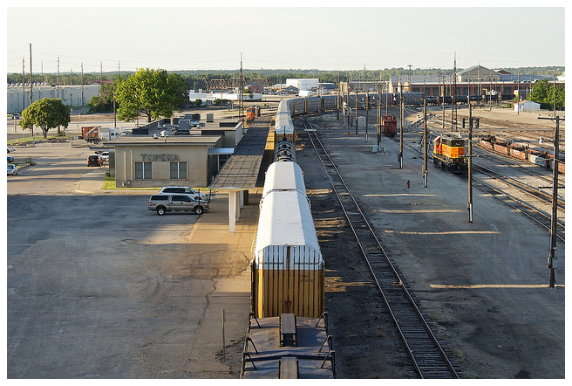

In [930]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['truck']);
imgIds = coco.getImgIds(catIds=catIds);
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

# load and display image
# I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
# use url to load image
import skimage.io as io
I = io.imread(img['coco_url'])
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(I)
plt.show()

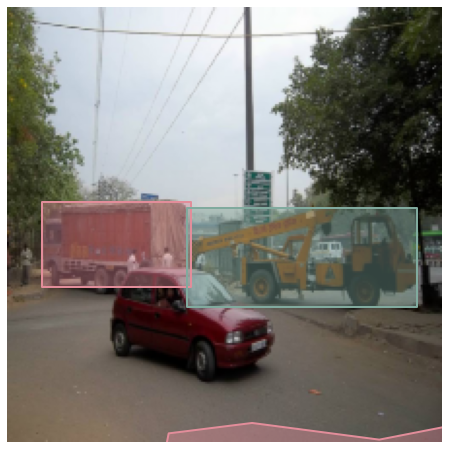

In [992]:
from skimage.transform import rescale, resize

# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['truck']);
imgIds = coco.getImgIds(catIds=catIds);
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
import skimage.io as io
I = io.imread(img['coco_url'])

img_size = 224
img_height = I.shape[0]
img_width = I.shape[1]
img_height_ratio = img_size / img_height
img_width_ratio = img_size / img_width

I_resized = resize(I, (img_size, img_size), anti_aliasing=True)

# load and display instance annotations
plt.figure(figsize=(8, 8))
plt.imshow(I_resized); plt.axis('off')
# annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
for ann in anns:
    ann['bbox'][0] = ann['bbox'][0] * img_width_ratio
    ann['bbox'][1] = ann['bbox'][1] * img_height_ratio
    ann['bbox'][2] = ann['bbox'][2] * img_width_ratio
    ann['bbox'][3] = ann['bbox'][3] * img_height_ratio

coco.showAnns(anns, draw_bbox=True)

In [993]:
# encode COCO image
coco_dm = COCOCaptionsDataModule()
img_transform = coco_dm.base_transform
print(img_transform)
img_transform = transforms.Compose([
    transforms.ToPILImage(),
    img_transform
])

img = img_transform(I).unsqueeze(0).to(device)
print(img.size())
image_embedding, _ = model.model.encode_image(img)

# encode label
DATA_DIR = Path("/misc/vlgscratch4/LakeGroup/shared_data/S_multimodal")
VOCAB_FILENAME = DATA_DIR / "vocab.json"
vocab = read_vocab(VOCAB_FILENAME)
label = torch.LongTensor([vocab["truck"]])
label_len = torch.LongTensor([1]).squeeze()

def encode_text(label, label_len):
    return model.model.encode_text(label.unsqueeze(0).to(device), label_len.unsqueeze(0).to(device))[0]

text_embedding = encode_text(label, label_len)

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
)
torch.Size([1, 3, 224, 224])


normalizing: [vmin, vmax] = [-0.000926, 0.007951] to [0, 1]


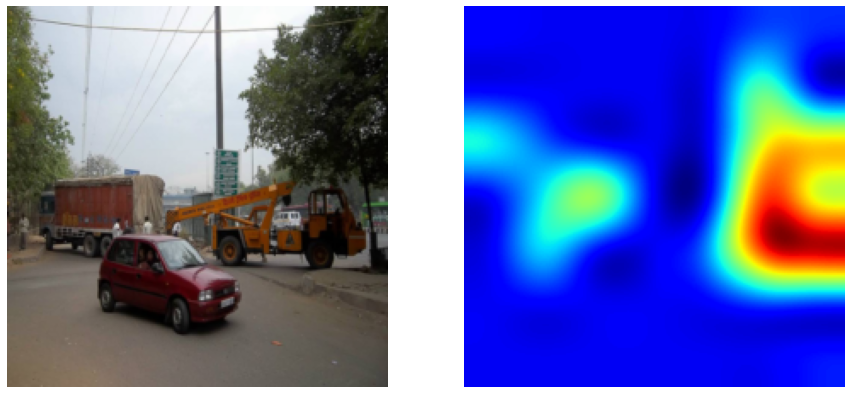

In [994]:
from scipy.ndimage import filters

def normalize(x: np.ndarray, vmin=None, vmax=None) -> np.ndarray:
    """Normalize to [0, 1].
    """
    if vmin is None:
        vmin = x.min()
    if vmax is None:
        vmax = x.max()
    print(f"normalizing: [vmin, vmax] = [{vmin:.6f}, {vmax:.6f}] to [0, 1]")
    x = x - vmin
    vmax = vmax - vmin
    if vmax > 0:
        x = x / vmax
    return x

def getRawAttMap(img, attn_map, interpolation='cubic', blur=True,
                 vmin=None, vmax=None, cmap='jet'):
    """Returns raw attention map"""
    if attn_map.shape != img.shape[:2]:
        import cv2
        attn_map = cv2.resize(
            attn_map, img.shape[1::-1],
            interpolation=getattr(cv2, "INTER_" + interpolation.upper()))
    if blur:
        attn_map = filters.gaussian_filter(attn_map, 0.02*max(img.shape[:2]))
    attn_map = normalize(attn_map, vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap(cmap)
    attn_map_c = np.delete(cmap(attn_map), 3, 2)
    return attn_map_c, attn_map

def show_heatmap(ax, np_img: np.ndarray, img: torch.Tensor, text_features: torch.Tensor, normalize=False, vmin=None, vmax=None):
    saliency_layer = "layer4"

    attn_map = gradCAM(
        model.vision_encoder.model,
        img,
        text_features,
        getattr(model.vision_encoder.model, saliency_layer),
        normalize_features=model.model.normalize_features,
    )
    attn_map = attn_map.squeeze()

    attn_map = attn_map.detach().cpu().numpy()
    attn_map_c, attn_map = getRawAttMap(np_img, attn_map, vmin=vmin, vmax=vmax)
    imshow(ax, attn_map_c)
    return attn_map

new_n_inv = transforms.Compose([
    transforms.Normalize(
    [-0.485/0.229, -0.456/0.224, -0.406/0.225], [1/0.229, 1/0.224, 1/0.225]),
])
    
plt.figure(figsize=(15, 10))
ax = plt.subplot(1, 2, 1)
plt.imshow(new_n_inv(img.squeeze()).permute((1, 2, 0)).cpu().numpy())
ax.axis('off')
ax = plt.subplot(1, 2, 2)
attn_map = show_heatmap(ax, new_n_inv(img.squeeze()).permute((1, 2, 0)).cpu().numpy(), img, text_embedding)

(-0.5, 223.5, 223.5, -0.5)

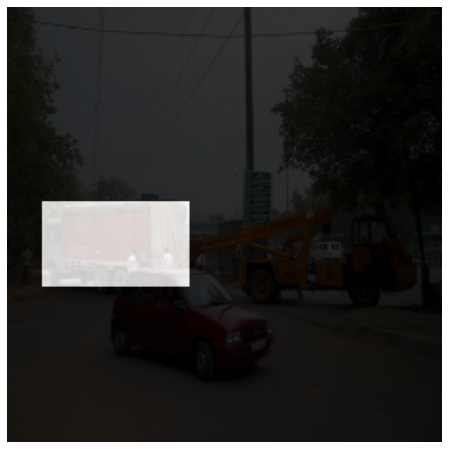

In [995]:
def get_bbox_mask(bbox):
    img_size = 224
    mask = np.zeros((img_size, img_size))
    for i in range(img_size):
        for j in range(img_size):
            if j >= bbox[0] and j <= bbox[0] + bbox[2] and i >= bbox[1] and i <= bbox[1] + bbox[3]:
                mask[i][j] = 1
    return mask

mask = get_bbox_mask(anns[0]['bbox'])
plt.figure(figsize=(8, 8))
plt.imshow(I_resized)
plt.imshow(mask, cmap='gray', alpha=0.8)
plt.axis('off')

In [996]:
# calculate pearson correlation
from scipy.stats import pearsonr
pearsonr(mask.flatten(), attn_map.flatten())

(0.12656234001288058, 3.2908504935790326e-178)

(-0.5, 223.5, 223.5, -0.5)

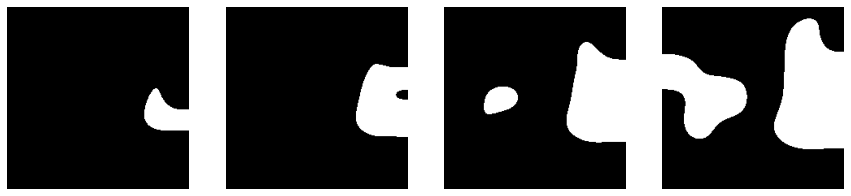

In [997]:
# create bounding box from attention map
def get_attn_mask(attn_map, threshold):
    img_size = 224
    mask = np.zeros((img_size, img_size))
    mask = (attn_map > threshold)
    return mask

attn_mask = get_attn_mask(attn_map, 0.5)

plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)
plt.imshow(get_attn_mask(attn_map, 0.8), cmap='gray')
plt.axis('off')  

plt.subplot(1, 4, 2)
plt.imshow(get_attn_mask(attn_map, 0.6), cmap='gray')
plt.axis('off')  
    
plt.subplot(1, 4, 3)
plt.imshow(get_attn_mask(attn_map, 0.4), cmap='gray')
plt.axis('off')  
           
plt.subplot(1, 4, 4)
plt.imshow(get_attn_mask(attn_map, 0.2), cmap='gray')
plt.axis('off')  

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[    0     0   224   224 33263]
 [  138    14    86   161 10749]
 [    0    58   105   104  6164]]


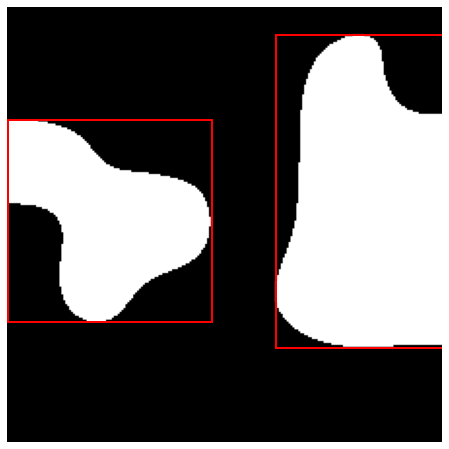

In [998]:
import cv2
from matplotlib.patches import Rectangle

mask = get_attn_mask(attn_map, 0.2).astype(np.uint8)
connectivity = 8
output = cv2.connectedComponentsWithStats(mask, connectivity, cv2.CV_32S)

num_labels = output[0]
labels = output[1]
bboxes = output[2]
print(labels)
print(bboxes)

plt.figure(figsize=(8, 8))
ax = plt.gca()
plt.imshow(mask, cmap='gray')
plt.axis('off')

for bbox_idx in range(1, len(bboxes)):
    bbox = bboxes[bbox_idx]
    rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
plt.show()